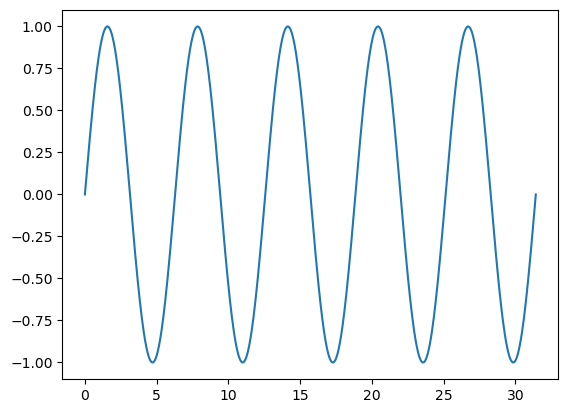

In [60]:
import matplotlib.pyplot as plt 
import numpy as np 

x = np.linspace(0, 10*np.pi, 1000)
y = np.sin(x)
plt.plot(x,y)

In [61]:
import math
import os
from tempfile import TemporaryDirectory
from typing import Tuple
x = 10
import torch
from torch import nn, Tensor
from torch.nn import TransformerEncoder, TransformerEncoderLayer
from torch.utils.data import dataset

In [62]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = torch.device('cpu')
print(device)

cpu


In [63]:
if torch.cuda.is_available():
    print("Cuda is available")
else:
    if 'cpu' in torch.__version__:
        print("NOT using cuda, torch version is +cpu instead of +cu")
    else:
        print("NOT using cuda, assert torch.cuda.is_available() failed")

Cuda is available


In [64]:
class TransformerModel(nn.Module):

    def __init__(self, ntoken: int, d_model: int, nhead: int, d_hid: int,
                 nlayers: int, dropout: float = 0.5):
        super().__init__()
        self.model_type = 'Transformer'
        self.pos_encoder = PositionalEncoding(d_model, dropout)
        encoder_layers = TransformerEncoderLayer(d_model, nhead, d_hid, dropout)
        self.transformer_encoder = TransformerEncoder(encoder_layers, nlayers)
        self.embedding = nn.Embedding(ntoken, d_model)
        self.d_model = d_model
        self.linear = nn.Linear(d_model, ntoken)

        self.init_weights()

    def init_weights(self) -> None:
        initrange = 0.1
        self.embedding.weight.data.uniform_(-initrange, initrange)
        self.linear.bias.data.zero_()
        self.linear.weight.data.uniform_(-initrange, initrange)

    def forward(self, src: Tensor, src_mask: Tensor = None, verbose = False) -> Tensor:
        """
        Arguments:
            src: Tensor, shape ``[seq_len, batch_size]``
            src_mask: Tensor, shape ``[seq_len, seq_len]``

        Returns:
            output Tensor of shape ``[seq_len, batch_size, ntoken]``
        """
        if verbose:
            print("Forward pass now ~~~~~~~~~~~~~~~~")
            print("Shape of input:", src.shape)
            print(src)
        src = self.embedding(src) * math.sqrt(self.d_model)
        if verbose:
            print("Shape after embedding:", src.shape)
            print(src)
        src = self.pos_encoder(src)
        if verbose:
            print("Shape after positional encoding:", src.shape)
            print(src)
        if src_mask is None:
            """Generate a square causal mask for the sequence. The masked positions are filled with float('-inf').
            Unmasked positions are filled with float(0.0).
            """
            src_mask = nn.Transformer.generate_square_subsequent_mask(len(src)).to(device)
        if verbose:
            print("Shape of mask:", src_mask.shape)
            print(src_mask)
        output = self.transformer_encoder(src, src_mask)
        if verbose:
            print("Shape after transformer encoding:", output.shape)
            print(output)
        output = self.linear(output)
        if verbose:
            print("Shape after linear:", output.shape)
            print(output)
        return output
    
    def __call__(self, src: Tensor, src_mask: Tensor = None, verbose = False) -> Tensor:
        return self.forward(src, src_mask = None, verbose = verbose)
    
    

In [65]:
class PositionalEncoding(nn.Module):

    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x: Tensor) -> Tensor:
        """
        Arguments:
            x: Tensor, shape ``[seq_len, batch_size, embedding_dim]``
        """
        # print("PE: Shape of input to PosEnc.forward():", x.shape)
        # print("PE: Shape of self.pe[:x.size(0)]:", self.pe[:x.size(0)].shape)
        x = x + self.pe[:x.size(0)].squeeze(1)
        # print("PE: Shape of output after adding PE:", x.shape)
        # print("PE: Shape of output after dropout:", self.dropout(x).shape)
        return self.dropout(x)
    
    def __call__(self, x: Tensor) -> Tensor:
        return self.forward(x)
    

In [66]:
# pip install portalocker
# pip install torchdata

In [67]:
# %%bash
# pip install torchtext

In [68]:
from torchtext.datasets import WikiText2
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

train_iter = WikiText2(split='train')
tokenizer = get_tokenizer('basic_english')
vocab = build_vocab_from_iterator(map(tokenizer, train_iter), specials=['<unk>'])
vocab.set_default_index(vocab['<unk>'])

def data_process(raw_text_iter: dataset.IterableDataset) -> Tensor:
    """Converts raw text into a flat Tensor."""
    data = [torch.tensor(vocab(tokenizer(item)), dtype=torch.long) for item in raw_text_iter]
    return torch.cat(tuple(filter(lambda t: t.numel() > 0, data)))

# ``train_iter`` was "consumed" by the process of building the vocab,
# so we have to create it again
train_iter, val_iter, test_iter = WikiText2()
train_data = data_process(train_iter)
val_data = data_process(val_iter)
test_data = data_process(test_iter)

def batchify(data: Tensor, bsz: int) -> Tensor:
    """Divides the data into ``bsz`` separate sequences, removing extra elements
    that wouldn't cleanly fit.

    Arguments:
        data: Tensor, shape ``[N]``
        bsz: int, batch size

    Returns:
        Tensor of shape ``[N // bsz, bsz]``
    """
    seq_len = data.size(0) // bsz
    print('batch size, seq_len: ', bsz, seq_len)
    data = data[:seq_len * bsz]
    data = data.view(bsz, seq_len).t().contiguous()
    return data.to(device)

batch_size = 20
eval_batch_size = 10
train_data = batchify(train_data, batch_size)  # shape ``[seq_len, batch_size]``
val_data = batchify(val_data, eval_batch_size)
test_data = batchify(test_data, eval_batch_size)

batch size, seq_len:  20 102499
batch size, seq_len:  10 21441
batch size, seq_len:  10 24185


In [69]:
train_data = data_process(train_iter)
train_data = train_data.to(device)

val_data = data_process(val_iter)
val_data = val_data.to(device)

test_data = data_process(test_iter)
test_data = test_data.to(device)

len(train_data)

2049990

In [70]:
train_data

tensor([   9, 3849, 3869,  ..., 2442, 4810,    3])

In [71]:
bptt = 256
def get_batch(source: Tensor, i: int) -> Tuple[Tensor, Tensor]:
    """
    Args:
        source: Tensor, shape ``[full_seq_len, batch_size]``
        i: int

    Returns:
        tuple (data, target), where data has shape ``[seq_len, batch_size]`` and
        target has shape ``[seq_len * batch_size]``
    """
    seq_len = min(bptt, len(source) - 1 - i)
    data = source[i:i+seq_len]
    target = source[i+1:i+1+seq_len].reshape(-1)
    return data, target

In [72]:
optimizer, scheduler = None, None

In [73]:
import time

criterion = nn.CrossEntropyLoss()
lr = 0.1  # learning rate

def train(model: nn.Module, verbose=False) -> None:
    
    model.train()  # turn on train mode
    total_loss = 0.
    log_interval = 200
    start_time = time.time()

    num_batches = len(train_data) // bptt
    for batch, i in enumerate(range(0, train_data.size(0) - 1, bptt)):
        data, targets = get_batch(train_data, i)
        data, targets = data.to(device), targets.to(device)

        output = model(data, verbose=verbose)
        # output_flat = output.view(-1, ntokens)
        output_flat = output # Band-aid fix for shape error
        loss = criterion(output_flat, targets)

        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
        optimizer.step()

        total_loss += loss.item()
        if batch % log_interval == 0 and batch > 0:
            lr = scheduler.get_last_lr()[0]
            ms_per_batch = (time.time() - start_time) * 1000 / log_interval
            cur_loss = total_loss / log_interval
            ppl = math.exp(cur_loss)
            print(f'| epoch {epoch:3d} | {batch:5d}/{num_batches:5d} batches | '
                  f'lr {lr:02.2f} | ms/batch {ms_per_batch:5.2f} | '
                  f'loss {cur_loss:5.2f} | ppl {ppl:8.2f}')
            total_loss = 0
            start_time = time.time()

def evaluate(model: nn.Module, eval_data: Tensor) -> float:
    model.eval()  # turn on evaluation mode
    total_loss = 0.
    with torch.no_grad():
        for i in range(0, eval_data.size(0) - 1, bptt):
            data, targets = get_batch(eval_data, i)
            seq_len = data.size(0)
            data = data.to(device)
            output = model(data)
            output_flat = output.view(-1, ntokens)
            total_loss += seq_len * criterion(output_flat, targets).item()
    return total_loss / (len(eval_data) - 1)

In [74]:
ntokens = len(vocab)  # size of vocabulary
emsize = 50  # embedding dimension (default 200)
d_hid = 200  # dimension of the feedforward network model in ``nn.TransformerEncoder``
nlayers = 2  # number of ``nn.TransformerEncoderLayer`` in ``nn.TransformerEncoder``
nhead = 2  # number of heads in ``nn.MultiheadAttention``
dropout = 0.2  # dropout probability

In [75]:
def new_model():
    model = TransformerModel(ntokens, emsize, nhead, d_hid, nlayers, dropout).to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.95)
    return model, optimizer, scheduler

In [76]:
model, optimizer, scheduler = new_model()

data, targets = get_batch(train_data, 0)
data, targets = data.to(device), targets.to(device)

output = model(data, verbose=True)

Forward pass now ~~~~~~~~~~~~~~~~
Shape of input: torch.Size([256])
tensor([    9,  3849,  3869,   881,     9, 20000,    83,  3849,    88,     0,
         3869,    21,   780, 28780,     2,  6182,     3,  3849,     4,     1,
         5023,    88,    20,     2,  1837,  1018,     7,    14,  3849,  3869,
          881,   629,   976,     2,    23,     8,  5790,   299,    12,   575,
          232,    67,   452,    19, 13722,     5,   757,     3,  2500,    17,
            1,  1767,  5637,     3,   155,     6,   246,   354,     6,   976,
            2,    24,    23,     1,   237,    67,     6,     1,  3849,    93,
            3,     0,     1,   156,  4419,     4,  5790,     5,   729,    12,
           58,  2096,    14,    43,  7075,     2,     1,   333,  1085,  3218,
            7,     1,    37,    67,     5,  1694,     1, 11219,     2,     8,
        19698,   313,  1063,  2082,     1,  1702,     4, 19009,    56,     1,
           95, 25357,   107,    52,  1938,  1644,   288,   598,     5,    

In [77]:
best_val_loss = float('inf')
epochs = 100

model, optimizer, scheduler = new_model()

with TemporaryDirectory() as tempdir:
    best_model_params_path = os.path.join(tempdir, "best_model_params.pt")

    for epoch in range(1, epochs + 1):
        epoch_start_time = time.time()
        train(model, verbose=False)
        val_loss = evaluate(model, val_data)
        val_ppl = math.exp(val_loss)
        elapsed = time.time() - epoch_start_time
        print('-' * 89)
        print(f'| end of epoch {epoch:3d} | time: {elapsed:5.2f}s | '
              f'valid loss {val_loss:5.2f} | valid ppl {val_ppl:8.2f}')
        print('-' * 89)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), best_model_params_path)

        scheduler.step()
    model.load_state_dict(torch.load(best_model_params_path)) # load best model states

| epoch   1 |   200/ 8007 batches | lr 0.10 | ms/batch 58.17 | loss  7.22 | ppl  1372.02
| epoch   1 |   400/ 8007 batches | lr 0.10 | ms/batch 63.65 | loss  6.98 | ppl  1076.15
| epoch   1 |   600/ 8007 batches | lr 0.10 | ms/batch 61.86 | loss  6.94 | ppl  1035.92
| epoch   1 |   800/ 8007 batches | lr 0.10 | ms/batch 63.66 | loss  6.91 | ppl  1005.23


KeyboardInterrupt: 

In [ ]:
test_loss = evaluate(model, test_data)
test_ppl = math.exp(test_loss)
print('=' * 89)
print(f'| End of training | test loss {test_loss:5.2f} | '
      f'test ppl {test_ppl:8.2f}')
print('=' * 89)

In [ ]:
# torch.cuda.current_device()     # The ID of the current GPU.
torch.cuda.get_device_name()

In [ ]:
model = TransformerModel(ntokens, emsize, nhead, d_hid, nlayers, dropout).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.95)

for _ in range(10):
    model.init_weights()

    test_loss = evaluate(model, val_data)
    print(f'test loss {test_loss:5.2f}')